<a href="https://colab.research.google.com/github/slcodia/PhilSaDataCamp-Codia/blob/main/Spatial_GEVD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Preliminaries: package installation

In [ ]:
!pip install pandas fiona shapely pyproj rtree folium matplotlib mapclassify
!pip install geopandas
!pip install openturns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import geopandas as gpd
import pandas as pd

# **Estimating Probabilities of Extreme Rainfalls in the Philippines**

In analyzing extreme rainfalls, we can analyze the historical maximum rainfall that occured.

In [ ]:
# other preliminaries to mapping
import matplotlib.pyplot as plt
# provincial shape file for mapping
province_loc = "drive/MyDrive/Colab Notebooks/Data/provinces/provinces.geojson"
province = gpd.read_file(province_loc)

# reading historical rainfall maxima per station
stations = pd.read_csv("drive/MyDrive/Colab Notebooks/Data/NOAA PH Weather Stations.csv")

Text(0.5, 1.0, 'Historical Single Day Rainfall Amount (mm) Recorded by PH Weather Stations')

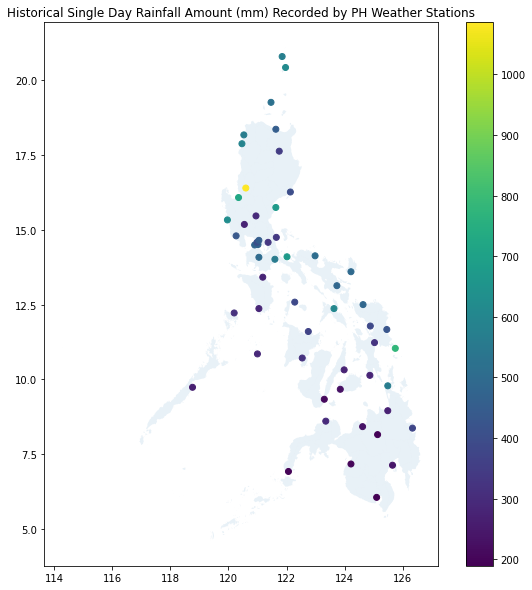

In [ ]:
# plotting historical maximum 1-day rainfall (Rx1day) per station

fig, ax1 = plt.subplots(figsize=(10, 10))

# basemap
province.plot(ax=ax1, alpha = 0.1)

# layer
plot_stations = gpd.GeoDataFrame(stations, geometry=gpd.points_from_xy(stations.LON, stations.LAT), crs = 4326)
plot_stations.plot(ax = ax1,column = 'Rx1day (mm)', legend = True)
plt.title("Historical Single Day Rainfall Amount (mm) Recorded by PH Weather Stations")

Data Sources: 

*   https://www.pagasa.dost.gov.ph/climate/climate-data
*   ftp://ftp.ncdc.noaa.gov/pub/data/gsod/



An initial analysis for this is that north and eastern part of the country **experienced** the highest rainfall magnitude compared to the other parts of the country. 

However, this does not answer the question "how frequent are these extreme events?"

# **Return Period and Return Levels**

**Obtaining probabilities is very important for risk assessment in the Philippines, especially that we are ranked 1 in the World Risk Index (World Risk Report 2022)** and is more insightful if we analyze the probabilities of the extreme events. 

In probabilistic risk assessment in hydrology and flood modelling, the concept of "**return periods**" or "**recurrence intervals**" is commonly used.

For example, if a 400 mm of rainfall is a 50-year return period event, then it has a 1/50 = 2% chance of being exceeded within a year. Another intuitive interpretation is that a 400 mm of rainfall is expected to happen once every 50 years.

Another example: how can we assure that a dam to be constructed can last at least 100 years if we do not have 100 years worth of data? Using current data, we will extrapolate and estimate the single day rainfall magnitude that will exist once in every 100 years.

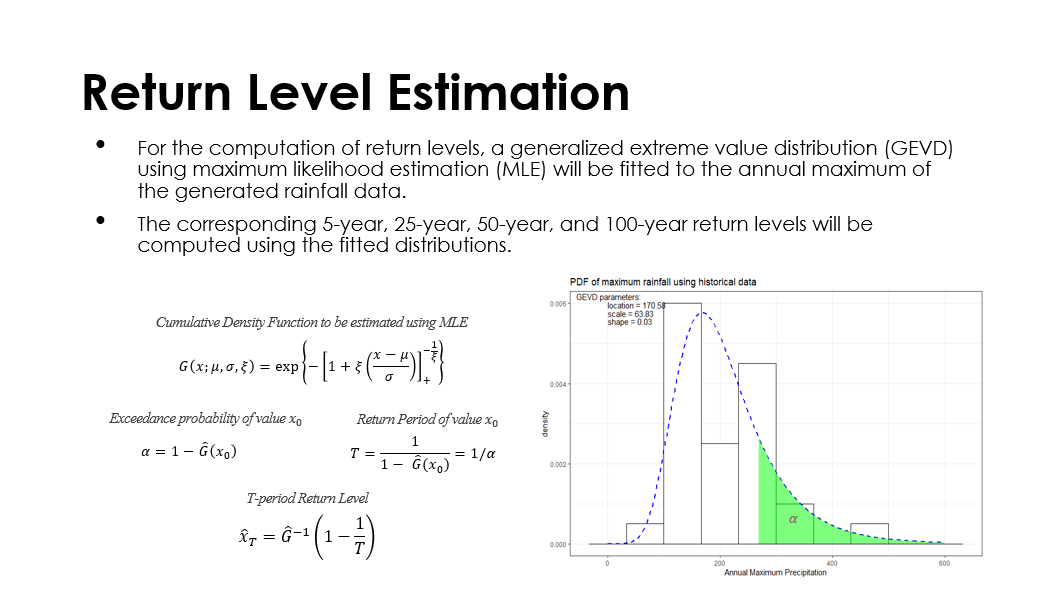

With this approach, even if we don't have a historically long data (i.e. observed data does not cover 50-100 years), we can determine the amount of rainfall that is exceeded once every 50 years, once every 100 years, and so on, to assist planning big ticket infrastructures such as dams and bridges.

This is also helpful in estimating more frequent extreme events, such as 5-year, 10-year, and 15-year return levels since these are the events that people encounter much often, which has great utility in disaster risk reduction and mitigation.


## Reading Rainfall Data

In [ ]:
rainfall_max = pd.read_csv("drive/MyDrive/Colab Notebooks/Data/max.spread.csv")
rainfall_max.head()

,YEAR,Laoag,Sinait-Vigan,Dagupan,Baguio,Basco Radar,Itbayat,Aparri,Calayan,Tuguegarao,...,Dipolog,Zamboanga,Malaybalay,Lumbia-El Salvador,Davao City,General Santos,Butuan,Hinatuan,Surigao,Cotabato
0,1981,400.050,115.062,109.982,214.884,NaN,NaN,375.500,27.940,260.096,...,36.068,48.006,NaN,17.018,99.060,7.112,27.940,320.040,NaN,NaN
1,1982,66.040,16.002,33.020,208.026,NaN,NaN,130.048,NaN,35.052,...,55.880,91.948,NaN,NaN,NaN,NaN,134.112,75.946,NaN,NaN
2,1983,16.002,17.018,23.876,300.990,NaN,NaN,99.060,1.016,41.910,...,70.104,39.878,119.888,45.974,17.018,30.988,107.950,34.036,NaN,NaN
3,1984,25.908,NaN,23.876,89.916,NaN,NaN,6.096,NaN,20.066,...,58.928,121.920,119.888,219.964,NaN,114.046,96.012,24.892,13.97,NaN
4,1985,214.122,27.940,93.980,121.920,NaN,NaN,94.996,NaN,22.098,...,46.990,55.118,NaN,28.956,49.022,3.048,77.978,41.910,41.91,NaN


## Fitting Univariate GEVD per station

Will just fit multiple univariate distributions by estimating the location $\mu$, scale $\sigma$, and shape $\xi$ parameters in each station using Maximum Likelihood Estimation. We will use the `openturns` package to fit a distribution.

In [ ]:
import openturns as ot
import numpy as np

After estimating the distribution, return levels can be computed. As a preliminary, note that the $p^{th}$ quantile of a random variable that follows GEV distribution is 

\begin{equation}
  \hat{x_p}=\left\{
  \begin{array}{@{}ll@{}}
    {\hat\mu+\frac{\hat\sigma(1-(-log(p))^\hat\xi)}{\hat\xi}}, & \text{if}\ \hat\xi \neq 0\ \\
      {\hat\mu-\hat\sigma(log(-log(p))}, & \text{if}\ \hat\xi = 0
  \end{array}\right.
\end{equation} 


Then, the T-year return level $x_T$ is calculated accordingly by setting 
$$
p = 1-\alpha=1-\frac{1}{T}
$$

The following function `qgevd` computes the $p^{th}$ quantile from an estimated distribution.

In [ ]:
# return level function
def qgevd(p, location, scale, shape):
  
  if shape !=0:
    quantile = location + (scale*(1-(-np.log(p))**shape))/shape
  elif shape ==0:
    quantile = location - scale*(np.log(-np.log(p)))
  
  return quantile

The following code outputs a dataframe of parameters and T-year rainfall return level per station.

In [ ]:
# initialize the parameter dataframe
pars = pd.DataFrame(columns=['station_name','location','scale','shape', 'rl_5', 'rl_10', 'rl_25','rl_50', 'rl_100'])

for i in range(1,len(rainfall_max.columns)):
    # getting specific column containing data from specific station i
    station_data = rainfall_max.iloc[:, i] 
    # removing NaN
    station_data = station_data[np.logical_not(np.isnan(station_data))] 
    # converting to ot.point object
    sample = ot.Sample([[p] for p in station_data]) 
    # fitting a GEVD to the data
    gev = ot.GeneralizedExtremeValueFactory().buildAsGeneralizedExtremeValue(sample) 
    # extracting the parameters
    loc0 = list(gev.getParameter())[0]
    scale0 = list(gev.getParameter())[1]
    shape0 = -list(gev.getParameter())[2]

    # n year return level calculation
    rl_5 = qgevd(p = 1-1/5, location = loc0, scale = scale0, shape = shape0) 
    rl_10 = qgevd(p = 1-1/10, location = loc0, scale = scale0, shape = shape0) 
    rl_25 = qgevd(p = 1-1/25, location = loc0, scale = scale0, shape = shape0)
    rl_50 = qgevd(p = 1-1/50, location = loc0, scale = scale0, shape = shape0)
    rl_100 = qgevd(p = 1-1/100, location = loc0, scale = scale0, shape = shape0)

    pars_temp = pd.DataFrame([[rainfall_max.columns[i], loc0, scale0, shape0, rl_5, rl_10, rl_25, rl_50, rl_100]], 
                             columns=['station_name','location','scale','shape', 'rl_5', 'rl_10', 'rl_25','rl_50', 'rl_100'], 
                             index = [i-1]) 
    # appending the parameters to the pars dataframe
    pars = pars.append(pars_temp)

In [ ]:
# we concatenate the parameter dataframe to the initial data frame containint PAGASA station coordinates
stations_pars = pd.concat([stations, pars], axis=1)
plot_stations_pars = gpd.GeoDataFrame(stations_pars, geometry=gpd.points_from_xy(stations_pars.LON, stations_pars.LAT), crs = 4326)
plot_stations_pars

,Region,Administrative Province,Station Name,LAT,LON,ALT,Rx1day (mm),Period Covered,geometry,station_name,location,scale,shape,rl_5,rl_10,rl_25,rl_50,rl_100
0,I,llocos Norte,Laoag,18.178,120.532,7.6,564.2,1907-2018,POINT (120.53200 18.17800),Laoag,197.394828,125.637875,0.312968,347.791715,400.339673,451.306790,480.457813,503.694190
1,I,llocos Sur,Sinait-Vigan,17.883,120.467,570.0,594.1,1903-2018,POINT (120.46700 17.88300),Sinait-Vigan,127.858030,89.567592,0.257335,239.313535,280.863326,323.094247,348.397584,369.369054
2,I,Pangasinan,Dagupan,16.082,120.350,20.0,722.6,1903-2018,POINT (120.35000 16.08200),Dagupan,128.930322,88.019835,-0.000000,260.954792,327.007283,410.464780,472.378319,533.834698
3,CAR,Benguet,Baguio,16.400,120.600,15010.0,1085.8,1902-2018,POINT (120.60000 16.40000),Baguio,261.078928,156.915378,0.626219,413.703436,450.430777,477.843988,489.889935,497.598555
4,II,Batanes,Basco Radar,20.433,121.967,1670.0,616.4,1903-2018,POINT (121.96700 20.43300),Basco Radar,131.843027,48.866264,-0.000000,205.139491,241.810071,288.143447,322.516193,356.635135
5,II,Batanes,Itbayat,20.800,121.850,1240.0,572.3,1971-2018,POINT (121.85000 20.80000),Itbayat,137.426497,48.461714,-0.000000,210.116159,246.483154,292.432948,326.521131,360.357612
6,II,Cagayan,Aparri,18.367,121.633,30.0,453.1,1903-2018,POINT (121.63300 18.36700),Aparri,97.583207,79.918297,-0.000000,217.455856,277.428731,353.204618,409.419499,465.219299
7,II,Cagayan,Calayan,19.267,121.467,130.0,522.2,1919-2018,POINT (121.46700 19.26700),Calayan,49.940185,49.982384,-0.000000,124.910762,162.418909,209.810554,244.968382,279.866611
8,II,Cagayan,Tuguegarao,17.633,121.750,620.0,349.7,1902-2018,POINT (121.75000 17.63300),Tuguegarao,126.676301,63.258603,-0.000000,221.560410,269.031395,329.011111,373.507490,417.675315
9,III,Aurora,Baler Radar,15.750,121.633,1780.0,675.6,1949-2018,POINT (121.63300 15.75000),Baler Radar,131.397837,52.175754,-0.000000,209.658337,248.812450,298.283775,334.984430,371.414093


## Visualization

The visualization below shows the amount of rainfall (mm) that comes once in every 5 years and once in every 100 years per weather station in the Philippines.

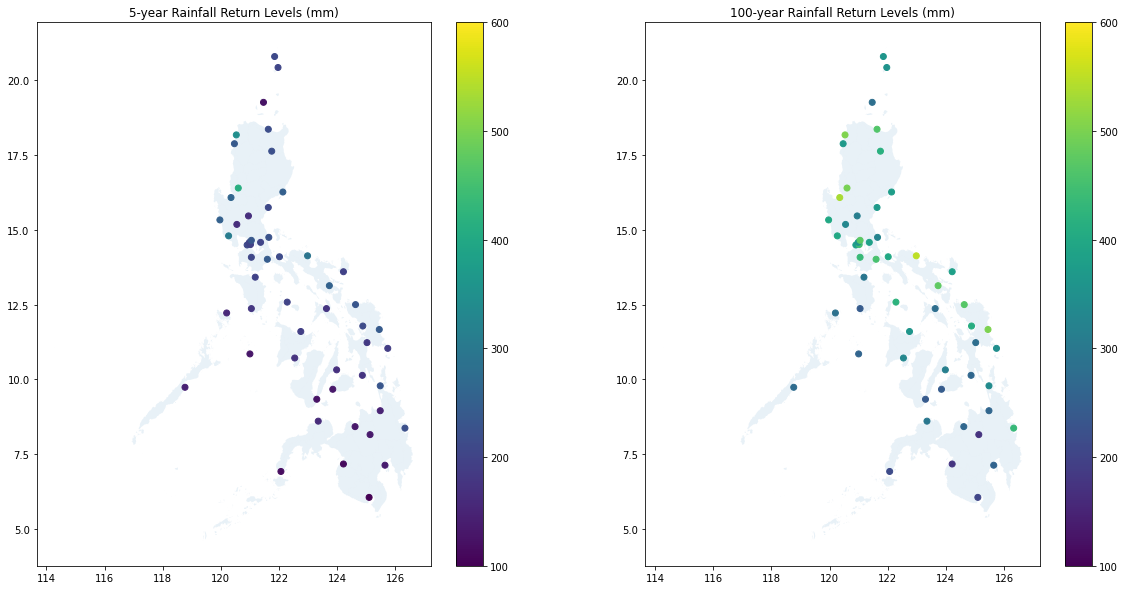

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)

# basemap
province.plot(ax=ax1, alpha = 0.1)
# point layer
plot_stations_pars.plot(column = 'rl_5',legend = True,vmin = 100, vmax = 600, ax = ax1)
# Title 
ax1.set_title("5-year Rainfall Return Levels (mm)")

# basemap
province.plot(ax=ax2, alpha = 0.1)
# point layer
plot_stations_pars.plot(column = 'rl_100',legend = True,vmin = 100, vmax = 600, ax = ax2)
# Title 
ax2.set_title("100-year Rainfall Return Levels (mm)")

# setting chart size
plt.gcf().set_size_inches(20, 10)


The left chart shows the amount of rainfall that comes every 5 years. The chart on the right is the amount of rainfall that comes every 100 years.
**Regions in the northern and eastern part receive more extreme rainfall levels.**

Major caveat for this is that has not been cleaned yet and the date range and data availability are not the same for all stations, which makes some of the estimates inaccurate.

------

# Provincial Level Estimates
Now that we have estimated the parameters and the return levels per weather station, it is more useful if the estimates are at a provincial level. For this, we will perform an interpolation procedure of the estimated parameters.

In the plot below, the red points are the provincial centroids while the green points are the locations of the weather stations.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.


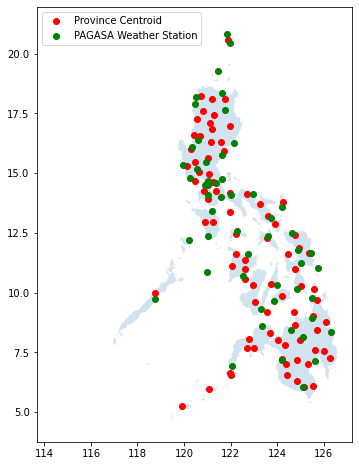

In [ ]:
province_centroid = province.centroid
fig, ax1 = plt.subplots(figsize=(10, 8))
province.plot(ax = ax1, alpha = 0.2, linewidth = 1)
province_centroid.plot(ax = ax1, color = 'red', label = 'Province Centroid')
plot_stations.plot(ax = ax1,color = 'green', label = 'PAGASA Weather Station')
leg = ax1.legend()

To recall, we have two geodataframes: 
 

*   `province`, which contains the boundaries per each province; and
*   `plot_stations_pars`, which contains the location of each weather station and the GEVD parameters to be used in computation of T-year return levels.

For now, we will assume that the values estimated for the **provincial centroid** represents the whole province.



## Spatial Interpolation of the Parameters

First, we define the interpolation method: Ordinary Kriging

$$\hat{x_0}=\sum_{i=1}^{m}\hat{w}_i x_i$$


where:

*   $\hat{x_0}$ is the estimate value on a location to be interpolated
*   $x_i$ the value at station $i$
*   $\hat{w}_i$ is the estimated weight of the station $i$

We will use the `pykrige` package to accomplish the spatial interpolation.

In [ ]:
!pip install pykrige
import pykrige as pyk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Now, create the ordinary kriging object by plugging in the required data as arrays: the x and y coordinates, and the value to be interpolated. 

We perform this three times, one per parameter (location $\mu$, scale $\sigma$, and shape $\xi$) to be interpolated.

In [ ]:
# Create the ordinary kriging objects

# location \mu
OK_loc = pyk.OrdinaryKriging(
    np.array(plot_stations_pars['LON']),
    np.array(plot_stations_pars['LAT']),
    np.array(plot_stations_pars['location']),
    variogram_model="linear",
    verbose=False,
    enable_plotting=False,
)

# scale \sigma
OK_scale = pyk.OrdinaryKriging(
    np.array(plot_stations_pars['LON']),
    np.array(plot_stations_pars['LAT']),
    np.array(plot_stations_pars['scale']),
    variogram_model="linear",
    verbose=False,
    enable_plotting=False,
)

# shape \xi
OK_shape = pyk.OrdinaryKriging(
    np.array(plot_stations_pars['LON']),
    np.array(plot_stations_pars['LAT']),
    np.array(plot_stations_pars['shape']),
    variogram_model="linear",
    verbose=False,
    enable_plotting=False,
)

We now use the ordinary kriging object for the interpolation on arbitrary points (provincial centroids).

In [ ]:
# z is the estimate, ss is the variance
z_loc, ss_loc = OK_loc.execute(style = "points", 
                               xpoints = np.array(province.centroid.x), 
                               ypoints = np.array(province.centroid.y))

z_scale, ss_scale = OK_scale.execute(style = "points", 
                               xpoints = np.array(province.centroid.x), 
                               ypoints = np.array(province.centroid.y))

z_shape, ss_shape = OK_shape.execute(style = "points", 
                               xpoints = np.array(province.centroid.x), 
                               ypoints = np.array(province.centroid.y))

In [ ]:
province["location"] = z_loc
province["scale"] = z_scale
province["shape"] = z_shape

## Estimating Return Levels per province 

We now then apply the qgevd function per province to estimate the corresponding 5, 10, 25, 50, and 100-year return levels.

Recall that the rows in the `province` dataframe represent a province.

In [ ]:
# 5-year return level
province['rl_5'] = province.apply(lambda z: qgevd(1-1/5, z['location'], z['scale'], z['shape']), 
               axis = 1,result_type='expand')

# 10-year return level
province['rl_10'] = province.apply(lambda z: qgevd(1-1/10, z['location'], z['scale'], z['shape']), 
               axis = 1,result_type='expand')

# 25-year return level
province['rl_25'] = province.apply(lambda z: qgevd(1-1/25, z['location'], z['scale'], z['shape']), 
               axis = 1,result_type='expand')

# 50-year return level
province['rl_50'] = province.apply(lambda z: qgevd(1-1/50, z['location'], z['scale'], z['shape']), 
               axis = 1,result_type='expand')

# 100-year return level
province['rl_100'] = province.apply(lambda z: qgevd(1-1/100, z['location'], z['scale'], z['shape']), 
               axis = 1,result_type='expand')

NameError: ignored

In [ ]:
province.head()

## Visualization per province

Text(0.5, 1.0, '50-year Rainfall Return Levels (mm)')

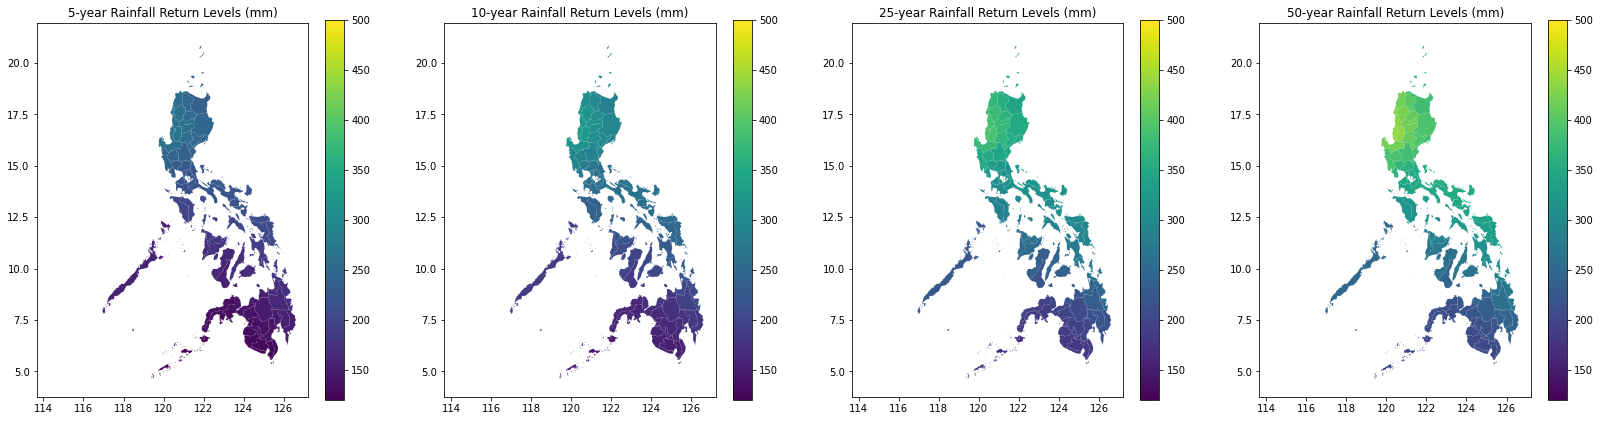

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (28,7))

# 5-year return level
province.plot(column = 'rl_5', legend = True, vmin = 120, vmax = 500,ax = ax1)
ax1.set_title("5-year Rainfall Return Levels (mm)")

#10-year return level
province.plot(column = 'rl_10', legend = True, vmin = 120, vmax = 500,ax = ax2)
ax2.set_title("10-year Rainfall Return Levels (mm)")

#25-year return level
province.plot(column = 'rl_25', legend = True, vmin = 120, vmax = 500,ax = ax3)
ax3.set_title("25-year Rainfall Return Levels (mm)")

# 50-year return level
province.plot(column = 'rl_50', legend = True, vmin = 120, vmax = 500,ax = ax4)
ax4.set_title("50-year Rainfall Return Levels (mm)")

Text(0.5, 1.0, '100-year Rainfall Return Levels (mm)')

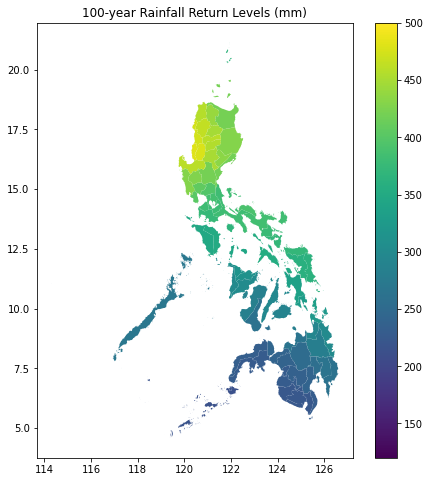

In [ ]:
province.plot(figsize = (8,8),column = 'rl_100', legend = True, vmin = 120, vmax = 500)
plt.title("100-year Rainfall Return Levels (mm)")

Luzon and eastern portion of Visayas experience the most extreme rainfalls in the country, and more frequently.

For future studies, we can downscale this down to city level while considering numerous landscape features such as mountains, water bodies, infrastructure, land-cover characteristics, and components of the climate 
system. 

This is particulary useful for the Philippines having a complex topography. For example, rainfall intensities recorded in Port Area, Manila is different from the rainfall intensities recorded in Science Garden, Quezon City, while being in the same region (NCR).

# Summary

To summarize, these are the steps that we did:


1.   Extract recorded annual rainfall maxima per station
2.   Fit univariate GEV distribution on the data from each of the stations by estimating the parameters $(\mu, \sigma, \xi)$
3.   Using the estimated parameters from each station, estimate the the same parameters located on the provincial centroid by spatial interpolation (Ordinary Kriging).
4.   Map the 5-year, 10-year, 50-year, and 100-year rainfall return levels for each of the Philippine provinces. 

